# Task 2 – Machine Learning Pipeline with PyCaret (Regression)
Dataset: **Used Car Prices (India)**

This notebook performs Task 2 of IT3385 Assignment:
- Data cleaning and preprocessing (based on Task 1)
- Train, validate, and develop ML pipeline using PyCaret
- Compare regression models and select the best one
- Evaluate and save the final model
- Register model with MLflow


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pycaret

In [2]:
!python --version

Python 3.10.18


In [3]:
print(pycaret.__version__)

3.3.2


In [4]:
# Load dataset
file_path = 'data/training/Used_Car_Prices_Task2.csv'  # update path if needed
df = pd.read_csv(file_path)
df.head()

,Brand_Model,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Price (INR Lakhs),Mileage (km/kg),Engine (CC),Power (bhp),Car_Age
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,5,175000.0,26.60,998,58.16,9
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,5,1250000.0,19.67,1582,126.20,4
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,5,450000.0,18.20,1199,88.70,8
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,7,600000.0,20.77,1248,88.76,7
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,5,1774000.0,15.20,1968,140.80,6


## Data Cleaning & Transformation (Continuation from Task 1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5874 entries, 0 to 5873
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand_Model        5874 non-null   object 
 1   Location           5874 non-null   object 
 2   Year               5874 non-null   int64  
 3   Kilometers_Driven  5874 non-null   int64  
 4   Fuel_Type          5874 non-null   object 
 5   Transmission       5874 non-null   object 
 6   Owner_Type         5874 non-null   object 
 7   Seats              5874 non-null   int64  
 8   Price (INR Lakhs)  5874 non-null   float64
 9   Mileage (km/kg)    5874 non-null   float64
 10  Engine (CC)        5874 non-null   int64  
 11  Power (bhp)        5874 non-null   float64
 12  Car_Age            5874 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 596.7+ KB


After importing the data that was minorly cleaned in EDA, it can now be seen that the columns I initially converted to category data types turned back into Object data types be default when placed into a new pandas dataframe. I will have to convert them back. 

In [6]:
# Convert categoricals
cat_cols = ['Location','Fuel_Type','Transmission','Owner_Type']
for col in cat_cols:
    df[col] = df[col].astype('category')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5874 entries, 0 to 5873
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Brand_Model        5874 non-null   object  
 1   Location           5874 non-null   category
 2   Year               5874 non-null   int64   
 3   Kilometers_Driven  5874 non-null   int64   
 4   Fuel_Type          5874 non-null   category
 5   Transmission       5874 non-null   category
 6   Owner_Type         5874 non-null   category
 7   Seats              5874 non-null   int64   
 8   Price (INR Lakhs)  5874 non-null   float64 
 9   Mileage (km/kg)    5874 non-null   float64 
 10  Engine (CC)        5874 non-null   int64   
 11  Power (bhp)        5874 non-null   float64 
 12  Car_Age            5874 non-null   int64   
dtypes: category(4), float64(3), int64(5), object(1)
memory usage: 437.0+ KB


Alright so now those features have been converted back to categorical data types. I can now perform some feature selection as mentioned in Task 1. 
- **Power and Engine** - Are **highly correlated independent variables** and may **cause multicollinearity issues.** Since we have seen that **Power** has a **bigger correlation**. to the **target variable (Price)**, I will thus **remove the other Engine column** thus helping eliminate the multicollinearity issue.
  
- **Brand_Model** - Has **too many unique categories,** hence I may not even be able to convert it into a numerical encoding using one-hot encoding. As a result, **due to the large number of unique categories,** this **Brand_Model may need to be dropped** for the sake of **minimizing model overfit.**

- **Year** - Previously in Task 1, I also had **derived a new column called **Car_Age**, which describes how old the car is before resale. This feature is **more useful for the analysis and modelling** in my opinion, and since it is **derived from the Year column**, the **Year should thus be dropped to reduce multicollinearity issues.**

In [8]:
df = df.drop(columns=['Brand_Model', 'Engine (CC)', 'Year'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5874 entries, 0 to 5873
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Location           5874 non-null   category
 1   Kilometers_Driven  5874 non-null   int64   
 2   Fuel_Type          5874 non-null   category
 3   Transmission       5874 non-null   category
 4   Owner_Type         5874 non-null   category
 5   Seats              5874 non-null   int64   
 6   Price (INR Lakhs)  5874 non-null   float64 
 7   Mileage (km/kg)    5874 non-null   float64 
 8   Power (bhp)        5874 non-null   float64 
 9   Car_Age            5874 non-null   int64   
dtypes: category(4), float64(3), int64(3)
memory usage: 299.3 KB


### On top of dropping unwanted features:
- **Kilometers_Driven** - is a **poorly correlated feature** because it **contains an outlier of 6500000km**, while the **Q1 and Q3** are only **between 34000km and 730000km respectively.** As such, I will be removing that one singular outlier to see if the skewness improves.


- **Fuel_Type, Transmission, and Owner_Type** - contain several outliers that **may affect the skewness of the price distribution.** However, I believe **these columns can be fixed using Pycaret's in-built data pre-processing function,** hence I will rely on that later on. 

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Kilometers_Driven,5874.0,58324.115594,9.215466e+04,171.0,33431.25,52621.5,72408.25,6500000.00
Seats,5874.0,5.283623,8.049613e-01,2.0,5.00,5.0,5.00,10.00
Price (INR Lakhs),5874.0,960155.090228,1.124828e+06,44000.0,351250.00,575000.0,1000000.00,16000000.00
Mileage (km/kg),5874.0,18.273829,4.371965e+00,0.0,15.26,18.2,21.10,33.54
Power (bhp),5874.0,113.272203,5.387332e+01,34.2,75.00,97.7,138.10,560.00
Car_Age,5874.0,5.523493,3.166025e+00,0.0,3.00,5.0,7.00,21.00


In [11]:
df = df[df["Kilometers_Driven"] != 6500000]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5873 entries, 0 to 5873
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Location           5873 non-null   category
 1   Kilometers_Driven  5873 non-null   int64   
 2   Fuel_Type          5873 non-null   category
 3   Transmission       5873 non-null   category
 4   Owner_Type         5873 non-null   category
 5   Seats              5873 non-null   int64   
 6   Price (INR Lakhs)  5873 non-null   float64 
 7   Mileage (km/kg)    5873 non-null   float64 
 8   Power (bhp)        5873 non-null   float64 
 9   Car_Age            5873 non-null   int64   
dtypes: category(4), float64(3), int64(3)
memory usage: 345.0 KB


In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Kilometers_Driven,5873.0,57227.286736,3.776382e+04,171.0,33425.00,52618.0,72400.0,775000.00
Seats,5873.0,5.283671,8.050213e-01,2.0,5.00,5.0,5.0,10.00
Price (INR Lakhs),5873.0,959211.816789,1.122598e+06,44000.0,351000.00,575000.0,1000000.0,16000000.00
Mileage (km/kg),5873.0,18.274221,4.372234e+00,0.0,15.26,18.2,21.1,33.54
Power (bhp),5873.0,113.247560,5.384478e+01,34.2,75.00,97.7,138.1,560.00
Car_Age,5873.0,5.524093,3.165960e+00,0.0,3.00,5.0,7.0,21.00


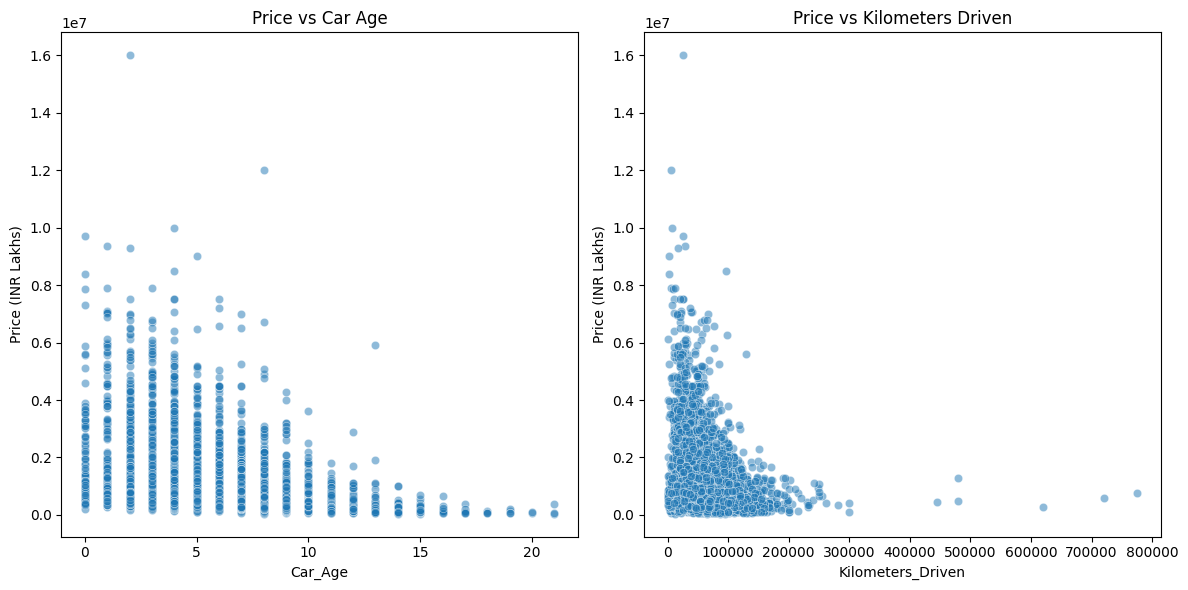

In [14]:
# Price vs Kilometers
# Scatter Plot
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Price vs Car Age
sns.scatterplot(x='Car_Age', y='Price (INR Lakhs)', data=df, alpha=0.5, ax=axes[0])
axes[0].set_title('Price vs Car Age')

# Price vs Kilometers Driven
sns.scatterplot(x='Kilometers_Driven', y='Price (INR Lakhs)', data=df, alpha=0.5, ax=axes[1])
axes[1].set_title('Price vs Kilometers Driven')

plt.tight_layout()
plt.show()


It seems that the skewness improved however it still shows no real correlation between Price and Kilometers_Driven.

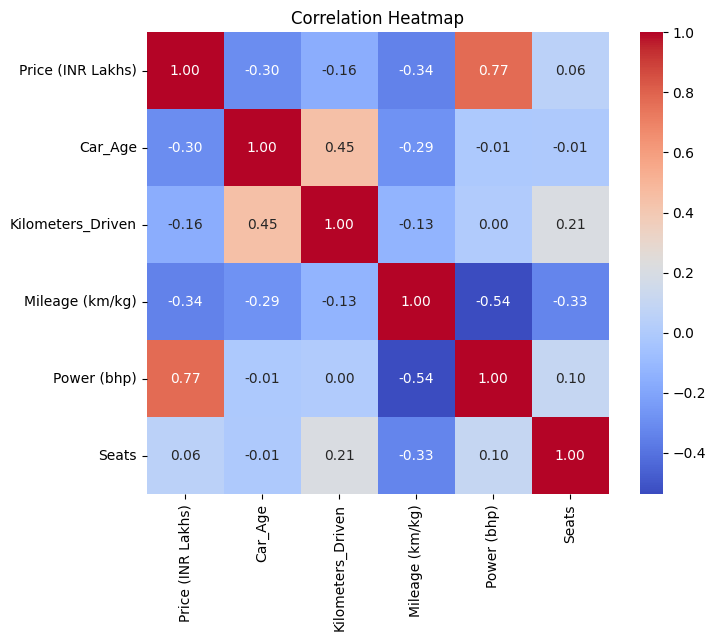

In [15]:
cols = ['Price (INR Lakhs)', 'Car_Age','Kilometers_Driven',
        'Mileage (km/kg)','Power (bhp)','Seats']

corr = df[cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, square=True)
plt.title('Correlation Heatmap')
plt.show()

If you refer back to the correlation matrix in Task 1, you can see that **the changes made here improved the correlation between Kilometers_Driven and Price (-0.01 to -0.16)** although it is **still a relatively low correlation it is still an improvement.** On top of that, **highly correlated independent variables have also been dropped (E.g., Engine and Year)** as such there are **no multicollinearity issues between the numerical variables.**

In [16]:
# 1) Clean column names to safe snake_case
def clean(c):
    c = re.sub(r'\s+', '_', c.strip())          # spaces -> _
    c = re.sub(r'[^\w]', '_', c)                # remove (, ), &, /
    c = re.sub(r'_+', '_', c).strip('_')        # collapse repeats
    return c

df.columns = [clean(c) for c in df.columns]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5873 entries, 0 to 5873
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Location           5873 non-null   category
 1   Kilometers_Driven  5873 non-null   int64   
 2   Fuel_Type          5873 non-null   category
 3   Transmission       5873 non-null   category
 4   Owner_Type         5873 non-null   category
 5   Seats              5873 non-null   int64   
 6   Price_INR_Lakhs    5873 non-null   float64 
 7   Mileage_km_kg      5873 non-null   float64 
 8   Power_bhp          5873 non-null   float64 
 9   Car_Age            5873 non-null   int64   
dtypes: category(4), float64(3), int64(3)
memory usage: 345.0 KB


In [18]:
# clean category VALUES so OHE outputs safe names
cat_cols = ['Location', 'Fuel_Type', 'Transmission', 'Owner_Type']  
for c in cat_cols:
    df[c] = (df[c].astype(str)
                   .str.strip()
                   .str.replace(r'[\s/&()+\-]+', '_', regex=True)
                   .str.replace(r'_+', '_', regex=True)
                   .str.strip('_'))

In [19]:
df.to_csv("Used_Car_Prices_Model_Training.csv", index=False)

## Initialize PyCaret Regression Experiment - Set-up the in-built pycaret pre-processing functions
NOTE: Ensure the the version of pycaret I was using (v3.3.2) had the necessary parameters used in the setup function for this to work

- Binning - Helps

In [19]:
from pycaret.regression import *

s = setup(
    data=df,
    target='Price_INR_Lakhs',     
    session_id=123,

    # Binning Continuous Variables
    bin_numeric_features=['Car_Age', 'Kilometers_Driven'],

    # Outlier Removal
    remove_outliers=True,
    outliers_threshold=0.05,
)

  File "C:\Users\aniqs\anaconda3\envs\mlops\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\aniqs\anaconda3\envs\mlops\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\aniqs\anaconda3\envs\mlops\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\aniqs\anaconda3\envs\mlops\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


,Description,Value
0,Session id,123
1,Target,Price_INR_Lakhs
2,Target type,Regression
3,Original data shape,"(5873, 10)"
4,Transformed data shape,"(5667, 26)"
5,Transformed train set shape,"(3905, 26)"
6,Transformed test set shape,"(1762, 26)"
7,Numeric features,5
8,Categorical features,4
9,Preprocess,True


# Compare Models
- In this task, I trained and validated models with 10-fold cross-validation across multiple metrics (MAE, RMSE, R², etc.)

In [20]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,170570.1234,137380024320.0000,368541.9500,0.8824,0.2676,0.1986,0.1700
catboost,CatBoost Regressor,175725.5732,145706109111.5269,378578.8492,0.8763,0.2709,0.2065,1.5670
lightgbm,Light Gradient Boosting Machine,180813.9367,149079100127.3512,383695.9008,0.8726,0.2692,0.2147,0.8370
rf,Random Forest Regressor,179687.9249,160893680919.6958,397900.0024,0.8620,0.2623,0.2055,0.4970
et,Extra Trees Regressor,195206.1472,182880289329.8801,424736.9669,0.8436,0.2747,0.2196,0.4530
gbr,Gradient Boosting Regressor,210662.7036,186021426822.3965,428519.0533,0.8413,0.3163,0.2556,0.2310
knn,K Neighbors Regressor,227416.7359,260733427712.0000,506868.2656,0.7745,0.3185,0.2638,0.1200
dt,Decision Tree Regressor,224501.4858,261033388617.2349,506846.1501,0.7722,0.3380,0.2453,0.1900
ridge,Ridge Regression,369666.5857,341354495339.2770,582255.6557,0.7081,0.7695,0.7326,1.1080
lr,Linear Regression,369698.8103,341374735012.8983,582269.2813,0.7081,0.7678,0.7330,1.7270


## Tune and Evaluate Best Model

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,181463.3438,174466842624.0000,417692.2812,0.8480,0.2941,0.2511
1,200026.5469,177904205824.0000,421786.9062,0.8494,0.2623,0.2053
2,178398.0000,180913455104.0000,425339.2188,0.8797,0.2637,0.1837
3,153636.3281,112141664256.0000,334875.5938,0.8744,0.2659,0.1876
4,158654.0625,110147772416.0000,331885.1875,0.9095,0.2466,0.1919
5,147169.5625,90713686016.0000,301187.1250,0.8927,0.2648,0.1723
6,179261.6406,156767371264.0000,395938.5938,0.8753,0.2647,0.1920
7,165565.2344,126291132416.0000,355374.6250,0.8938,0.2713,0.2059
8,184244.7812,145294245888.0000,381174.8125,0.8865,0.2398,0.1879


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


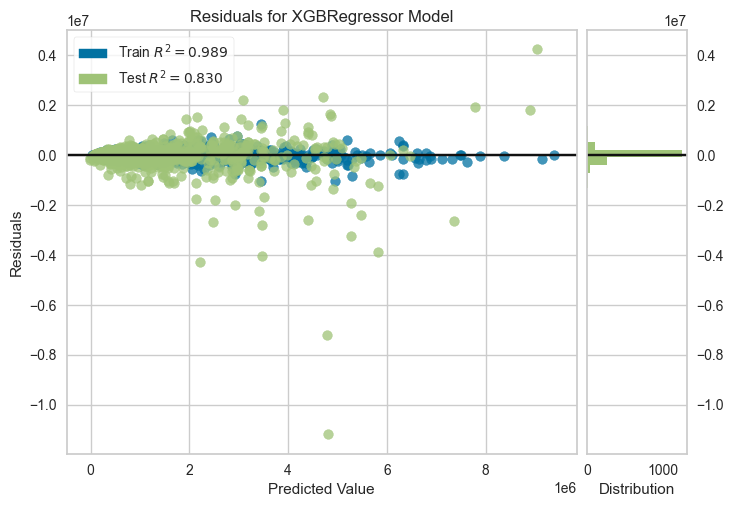

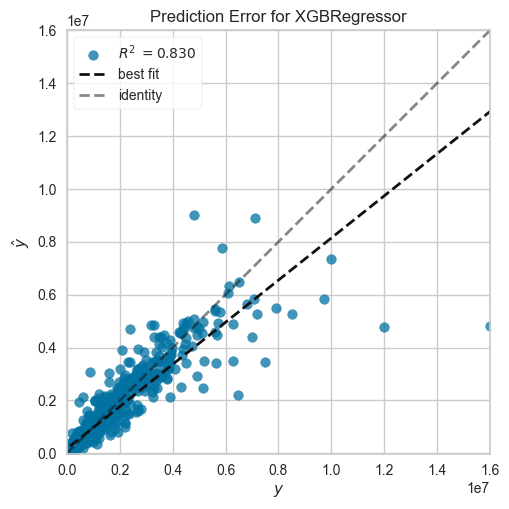

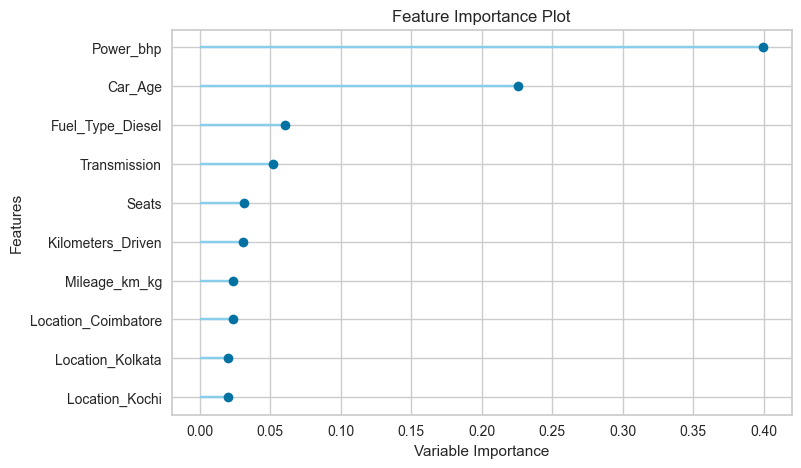

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [21]:
tuned_model = tune_model(best_model)
plot_model(tuned_model, plot='residuals')
plot_model(tuned_model, plot='error')
plot_model(tuned_model, plot='feature')
evaluate_model(tuned_model)

## Finalize Model & Predictions

In [22]:
final_model = finalize_model(tuned_model)

In [23]:
# Case 1: Evaluate on holdout/Testing dataset (target present)
preds_eval = predict_model(final_model)
preds_eval.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,98999.6484,107227258880.0000,327455.7500,0.9269,0.1628,0.1167


,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Mileage_km_kg,Power_bhp,Car_Age,Price_INR_Lakhs,prediction_label
3877,Kolkata,15305,Petrol,Manual,First,5,18.900000,82.000000,4,375000.0,4.066474e+05
1172,Hyderabad,96000,Diesel,Automatic,First,5,12.350000,187.740005,7,1898000.0,2.067785e+06
4534,Pune,46000,Diesel,Automatic,Second,5,16.360001,187.699997,6,2400000.0,2.572890e+06
547,Jaipur,63642,Diesel,Manual,First,5,27.299999,98.599998,4,565000.0,5.945946e+05
4015,Hyderabad,38000,Petrol,Automatic,First,5,14.700000,177.500000,4,1600000.0,2.164752e+06


In [24]:
# Case 2: Simulate new unseen data (target removed)
unseen_data = df.drop(columns=['Price_INR_Lakhs'])
preds_unseen = predict_model(final_model, data=unseen_data)
preds_unseen.head()

,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Mileage_km_kg,Power_bhp,Car_Age,prediction_label
0,Mumbai,72000,CNG,Manual,First,5,26.600000,58.160000,9,2.270065e+05
1,Pune,41000,Diesel,Manual,First,5,19.670000,126.199997,4,1.270320e+06
2,Chennai,46000,Petrol,Manual,First,5,18.200001,88.699997,8,4.164310e+05
3,Chennai,87000,Diesel,Manual,First,7,20.770000,88.760002,7,6.547913e+05
4,Coimbatore,40670,Diesel,Automatic,Second,5,15.200000,140.800003,6,1.788165e+06


## Save Model Pipeline
- Experiment logging was enabled in PyCaret setup, with results stored in MLflow under the experiment used_car_prices_regression.

In [25]:
from pycaret.regression import save_model, get_leaderboard
import mlflow

In [26]:
# Save the full PyCaret pipeline locally 
model_base = "used_car_price_pipeline"
model_path = save_model(final_model, model_base)  # creates "used_car_price_pipeline.pkl"

Transformation Pipeline and Model Successfully Saved


In [27]:
save_model(final_model, 'used_car_price_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Kilometers_Driven', 'Seats',
                                              'Mileage_km_kg', 'Power_bhp',
                                              'Car_Age'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Location', 'Fuel_Type',
                                              'Transmission', 'Owner_Type'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
  

In [28]:
# Save the leaderboard for logging
lb = get_leaderboard()
lb_path = "leaderboard.csv"
lb.to_csv(lb_path, index=False)

In [29]:
# load pipeline
loaded_best_pipeline = load_model('used_car_price_pipeline')
loaded_best_pipeline

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=C:\Users\aniqs\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['Kilometers_Driven', 'Seats',
                                             'Mileage_km_kg', 'Power_bhp',
                                             'Car_Age'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['Location', 'Fuel_Type',
                                             'Transmission', 'Owner_Type'],
                                    transformer=Simp...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=-1,
                              num_parallel_tree=None, ...))])

## Register Model with MLflow

In [35]:
import pandas as pd
import mlflow
import mlflow.sklearn
from pycaret.regression import load_model, predict_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

FEATURES = [
    "Location","Kilometers_Driven","Fuel_Type","Transmission","Owner_Type",
    "Seats","Mileage_km_kg","Power_bhp","Car_Age"
]

df = pd.read_csv("Used_Car_Prices_Task2.csv")
# Align column names if needed
df = df.rename(columns={
    "Price (INR Lakhs)": "Price_INR_Lakhs",
    "Mileage (km/kg)": "Mileage_km_kg",
    "Power (bhp)": "Power_bhp"
})

m = load_model("used_car_price_pipeline")  # base name, no .pkl

mlflow.set_experiment("used_car_prices_regression")
with mlflow.start_run(run_name="used_car_price_run_with_metrics") as run:
    # score
    scored = predict_model(m, data=df[FEATURES].copy())
    y_true = df["Price_INR_Lakhs"].values
    y_pred = scored["prediction_label"].values

    # metrics
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)

    mlflow.log_metrics({"mae": mae, "rmse": rmse, "r2": r2})

    # (Optional) log & register model properly so it shows under "Models"
    mlflow.sklearn.log_model(
        sk_model=m,
        name="model",
        registered_model_name="used_car_price_model"
    )

print("Logged metrics. Refresh the run, Model metrics tab.")

Transformation Pipeline and Model Successfully Loaded


2025/08/28 15:48:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'used_car_price_model' already exists. Creating a new version of this model...
Created version '3' of model 'used_car_price_model'.


Logged metrics. Refresh the run, Model metrics tab.


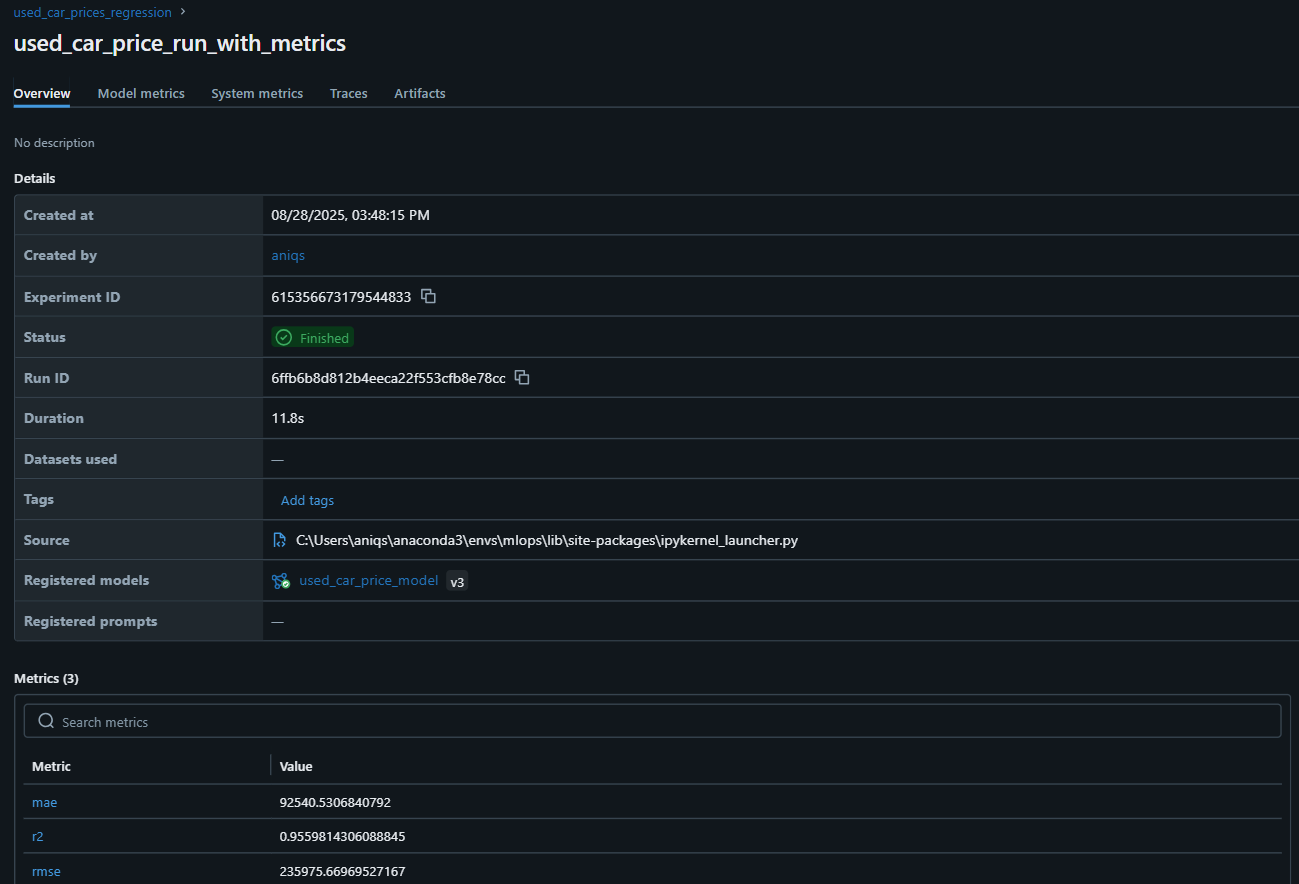

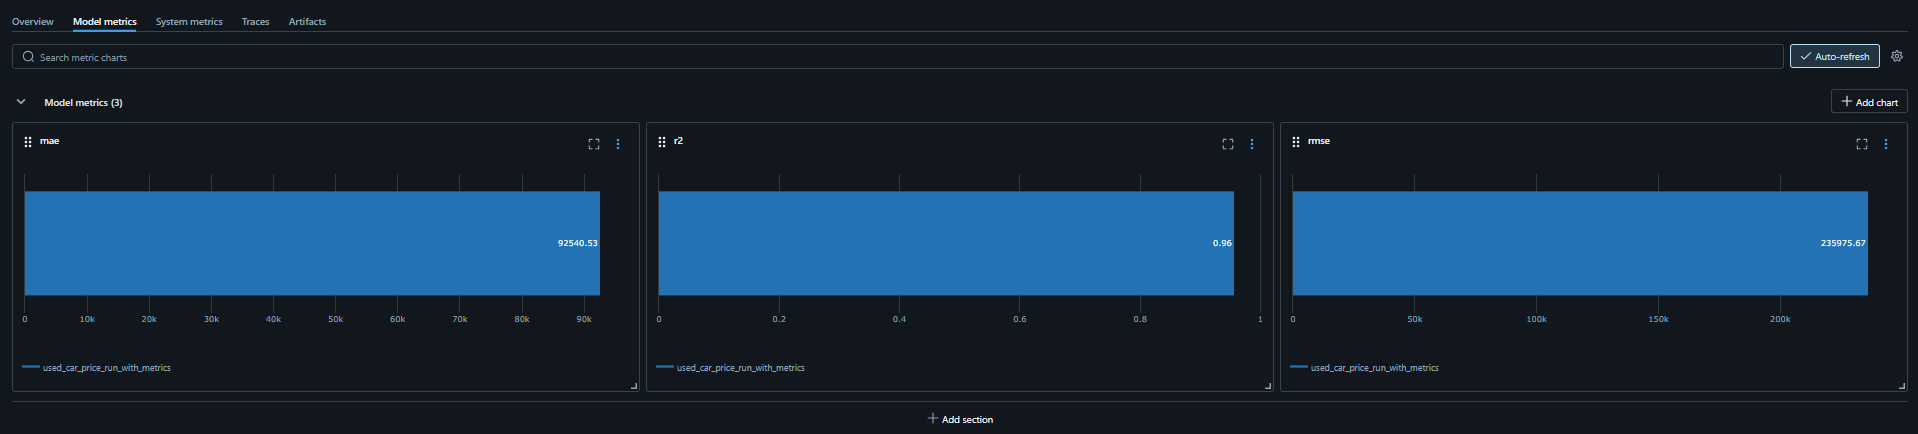